In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.optimize as optimize

In [2]:
import numpy as np

def nll(theta,t):
    f,tau1,tau2 = theta
    return -np.sum(np.log(f*(1/tau1)*np.exp(-t/tau1)+(1-f)*(1/tau2)*np.exp(-t/tau2)))  

class tcdecay_distribution:
    
    # constructors
    def __init__(self, f, tau1, tau2):
        self.f = float(f)
        self.tau1 = float(tau1)
        self.tau2 = float(tau2)
        
    # method to return exponential distribution    
    def evaluate_md(self,t):
        return self.f*(1/self.tau1)*np.exp(-t/self.tau1)+(1-self.f)*(1/self.tau2)*np.exp(-t/self.tau2)
    
    # method to return maximum value of distribution  
    def maximum(self):
        return 10.0
    
    # method to return random number with distribution
    # choose numpy random exponential or custom code 'calum'    
    def random_val(self):           
        x1 = 0.
        x2 = 0.
        x3 = 1.
        while ( x3 > x2 ):
            x1 = np.random.uniform()
            x1 = x1*7.
            x2 = self.evaluate_md(x1)
            x3 = np.random.uniform() * self.maximum()
        
        return x1
    
    # integrates area under the curve, in this example should be normalised
    # therefore always roughly equal to 1
    def numeric_integral(self,lo,hi,npoints=100000):
        
        sumf = 0
        
        for i in range(0,npoints):
            x = lo+np.random.uniform()*(hi-lo)
            sumf += self.evaluate_md(x)
            
        return sumf*(hi-lo)/npoints
    
    def nll(self,theta,t):
        f,tau1,tau2 = theta
        return -np.sum(np.log(f*(1/tau1)*np.exp(-t/tau1)+(1-f)*(1/tau2)*np.exp(-t/tau2)))  
    
    # performs an observation by taking n_muons random values
    # of the distribution
    def observation(self,n_muons=10000,method='TNC'):
        results = []
        for i in range(0,n_muons):
            results.append(self.random_val())
        
        mle_estimates = optimize.minimize(self.nll, [self.f, self.tau1, self.tau2], args=(np.array(results)),method=method)
        params = mle_estimates['x']
        # return (parameters_estimates, results)
        return params, np.array(results)

In [18]:
true_params = [0.74849409,  0.1978367 ,  1.30720393]

In [3]:
test = tcdecay_distribution(0.74849409,  0.1978367 ,  1.30720393)

In [4]:
test.numeric_integral(0,10)

0.99836607431997759

In [5]:
val, result = test.observation()  
val,result.shape

(array([ 0.72325671,  0.19008336,  1.19257345]), (10000,))

In [26]:
np.max(result)

6.9992773610430943

In [6]:
val, result = test.observation(method='Nelder-mead')  
val,result.shape

(array([ 0.7381317 ,  0.19707541,  1.27325337]), (10000,))

In [7]:
data = np.loadtxt('DecayTimesData.txt')
data.shape

(10000,)

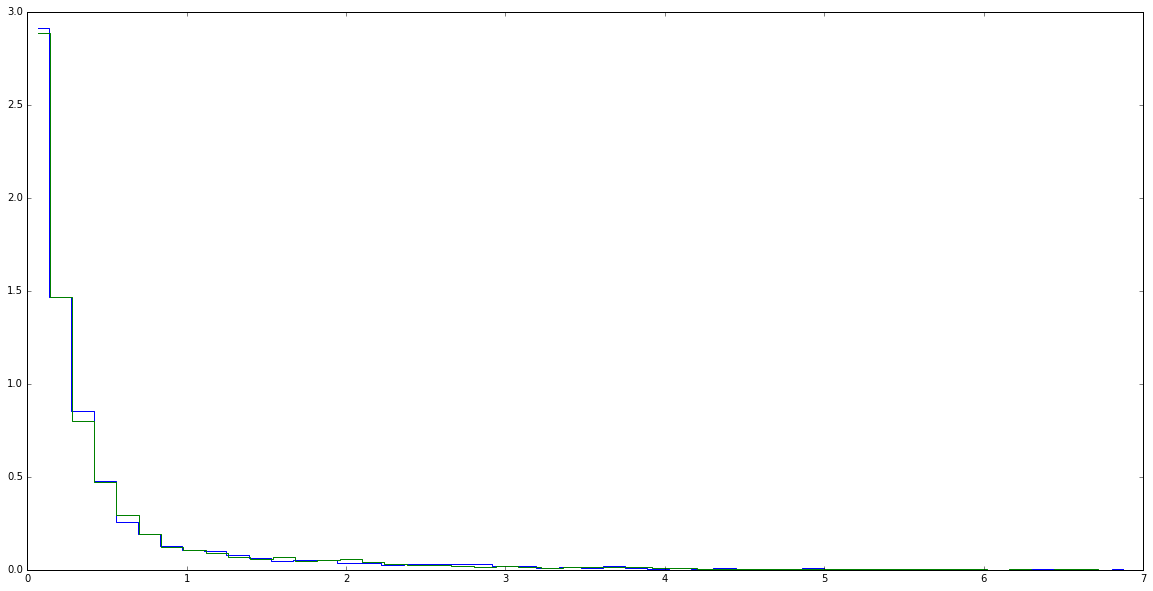

In [8]:
f,bins = np.histogram(data,bins=50,normed=True)
step = bins[1]-bins[0]
plt.figure(figsize=(20,10))
plt.plot(bins[1:]-step/2,f,drawstyle='steps-mid')
step

n, bins = np.histogram(result, bins=50, normed=True)

step = (bins[1]-bins[0])/2
plt.plot(bins[1:]-step,n,drawstyle='steps-mid')

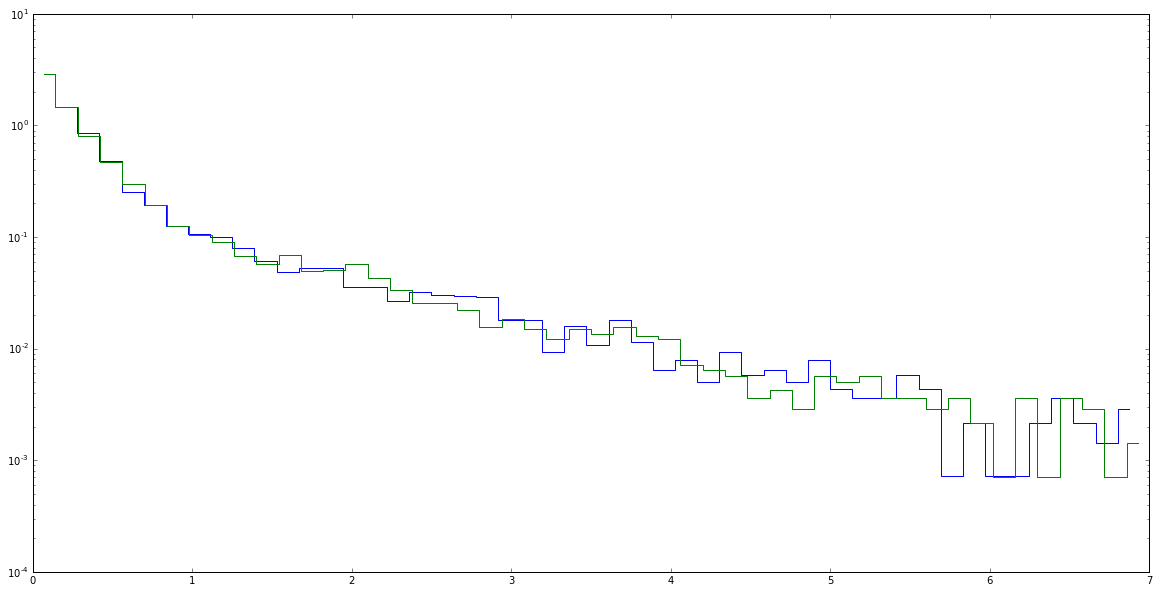

In [9]:
f,bins = np.histogram(data,bins=50,normed=True)
step = bins[1]-bins[0]
plt.figure(figsize=(20,10))
plt.plot(bins[1:]-step/2,f,drawstyle='steps-mid')
step

n, bins = np.histogram(result, bins=50, normed=True)

step = (bins[1]-bins[0])/2
plt.plot(bins[1:]-step,n,drawstyle='steps-mid')

plt.yscale('log')

test = tcdecay_distribution(0.74849409,  0.1978367 ,  1.30720393)
results = []
for _ in range(50):
    results.append(test.observation(method='Nelder-mead')[0])

In [13]:
results_tnc = np.load('/home/calum/Documents/NumRep/max_likelihood/run_sim_tnc.npy')
results_nm = np.load('/home/calum/Documents/NumRep/max_likelihood/run_sim_nm.npy')

In [14]:
np.array(results_tnc).shape, np.array(results_nm).shape

((5000, 3), (5000, 3))

(0.74849409, 0.74187213979686506, 0.74071513951410617)

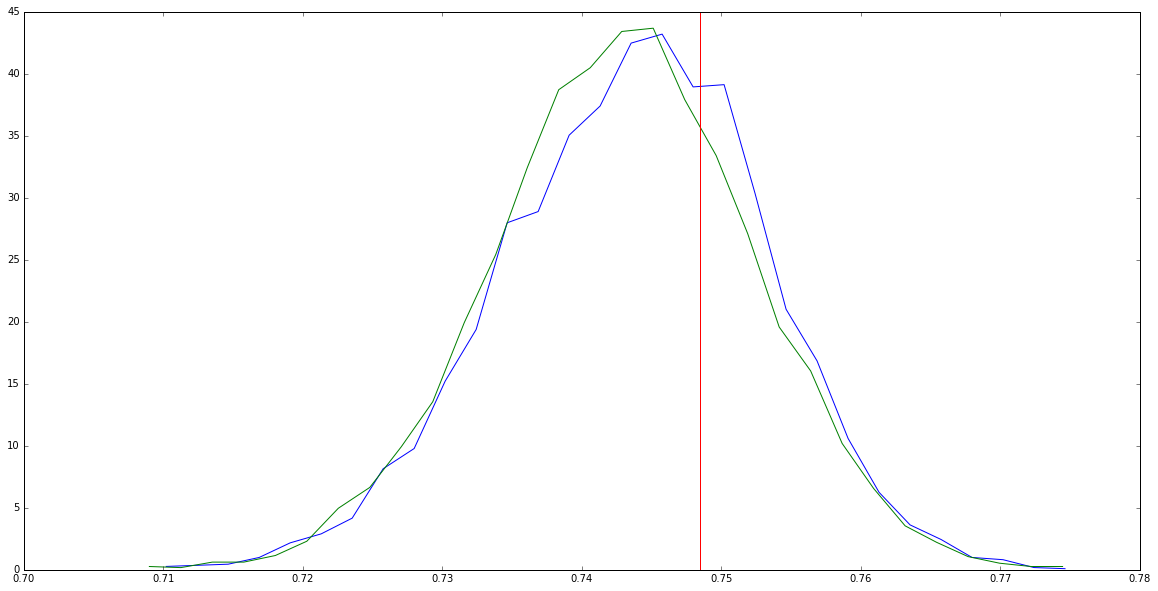

In [32]:
n, bins = np.histogram(np.array([row[0] for row in results_tnc if 10 >row[0] > 0]), bins=30, normed=True)

plt.figure(figsize=(20,10))
step = (bins[1]-bins[0])/2
plt.plot(bins[1:]+step,n)

n, bins = np.histogram(np.array([row[0] for row in results_nm if 10 >row[0] > 0]), bins=30, normed=True)

step = (bins[1]-bins[0])/2
plt.plot(bins[1:]+step,n)

plt.plot([true_params[0],true_params[0]],[0,45])
true_params[0],np.median([row[0] for row in results_tnc if 10 >row[0] > 0]),np.median([row[0] for row in results_nm if 10 >row[0] > 0])

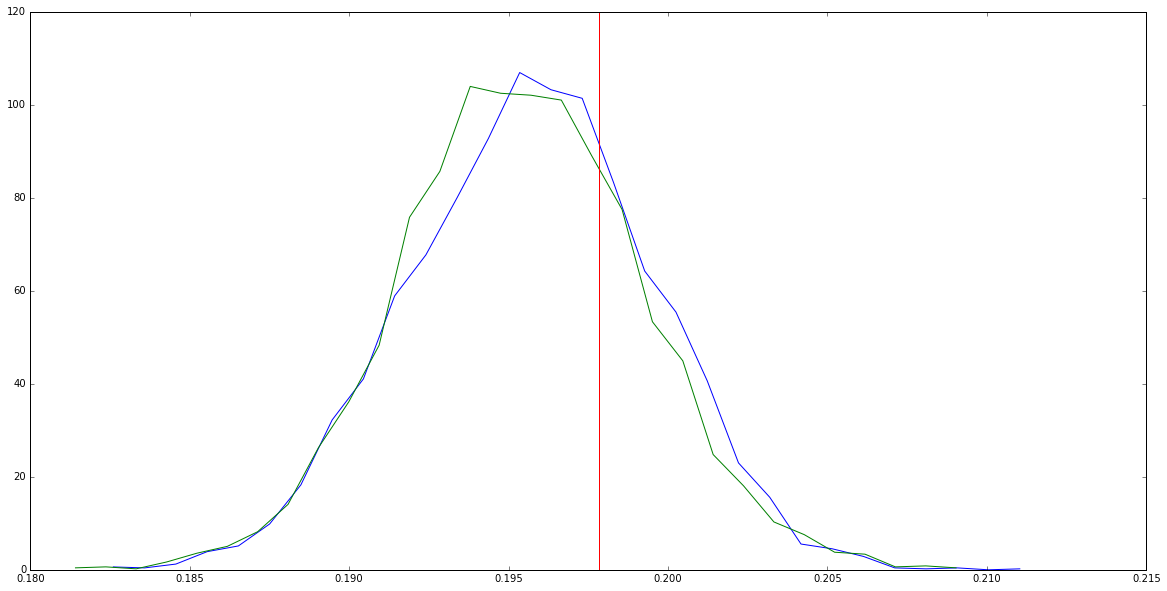

In [23]:
n, bins = np.histogram(np.array([row[1] for row in results_tnc if 10 >row[0] > 0]), bins=30, normed=True)

plt.figure(figsize=(20,10))
step = (bins[1]-bins[0])/2
plt.plot(bins[1:]-step,n)

n, bins = np.histogram(np.array([row[1] for row in results_nm if 10 >row[0] > 0]), bins=30, normed=True)

step = (bins[1]-bins[0])/2
plt.plot(bins[1:]-step,n)
plt.plot([true_params[1],true_params[1]],[0,120])

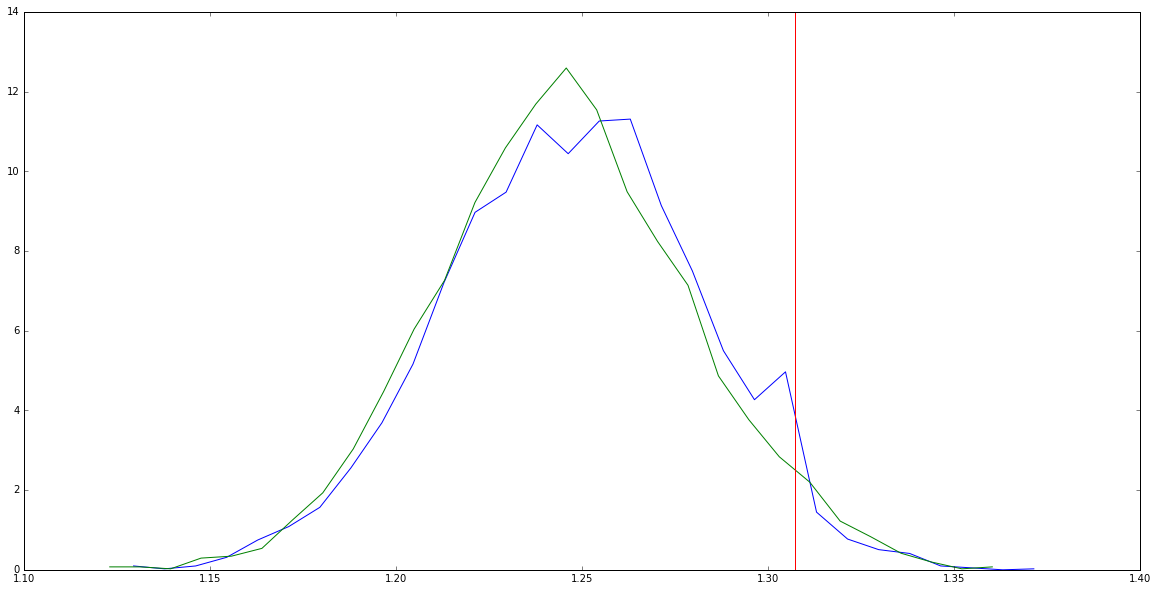

In [25]:
n, bins = np.histogram(np.array([row[2] for row in results_tnc if 10 >row[0] > 0]), bins=30, normed=True)

plt.figure(figsize=(20,10))
step = (bins[1]-bins[0])/2
plt.plot(bins[1:]-step,n)

n, bins = np.histogram(np.array([row[2] for row in results_nm if 10 >row[0] > 0]), bins=30, normed=True)

step = (bins[1]-bins[0])/2
plt.plot(bins[1:]-step,n)
plt.plot([true_params[2],true_params[2]],[0,14])

In [107]:
len([row for row in results if row[0] < 0])

2

In [ ]:
test.num